In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import pandas as pd
from itertools import cycle
import math
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score, recall_score
import re
import nltk
from nltk.stem import WordNetLemmatizer
import warnings



# Aux Functions

## Ploting

In [6]:
def plot_roc_curves(class_names, fpr, tpr, roc_auc, figsize=(15, 10)):
    distinct_colors = [
        '#9b59b6', '#3498db', '#e74c3c', '#2ecc71',
        '#f39c12', '#1abc9c', '#d35400'
    ]
    
    plt.figure(figsize=figsize)
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Toxicity Category')
    plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_pr_curves(class_names, recall, precision, avg_precision, figsize=(15, 10)):
    distinct_colors = [
        '#9b59b6', '#3498db', '#e74c3c', '#2ecc71',
        '#f39c12', '#1abc9c', '#d35400'
    ]
    
    plt.figure(figsize=figsize)
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                label=f'{class_name} (AP = {avg_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Each Toxicity Category')
    plt.legend(loc="lower left", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_metrics_heatmap(metrics_df, figsize=(10, 6)):
    vibrant_purple_palette = ['#4A148C', '#6A1B9A', '#8E24AA', '#AB47BC', '#CE93D8']
    
    plt.figure(figsize=figsize)
    vibrant_cmap = LinearSegmentedColormap.from_list("vibrant_purple", vibrant_purple_palette[::-1])
    
    sns.heatmap(metrics_df, annot=True, cmap=vibrant_cmap, fmt='.3f', 
                cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
    plt.title('Classification Metrics per Toxicity Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_confusion_matrices(class_names, results, figsize=(15, 10)):
    purple_palette = ['#9b59b6', '#AF7AC5', '#C39BD3', '#D7BDE2', '#E8DAEF']
    dark_purple_palette = ['#6A0DAD', '#8E44AD', '#9B59B6', '#B19CD9', '#D2B4DE']
    
    n_classes = len(class_names)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)
    
    plt.figure(figsize=(15, 4*n_rows))
    
    custom_cmaps = []
    for i in range(len(class_names)):
        if i % 2 == 0:
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"custom_purple_{i}", 
                                                                purple_palette[::-1]))
        else:
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"dark_purple_{i}", 
                                                                dark_purple_palette[::-1]))
    
    for i, class_name in enumerate(class_names):
        cm = np.array([[results['per_class'][class_name]['confusion_matrix']['tn'],
                       results['per_class'][class_name]['confusion_matrix']['fp']],
                      [results['per_class'][class_name]['confusion_matrix']['fn'],
                       results['per_class'][class_name]['confusion_matrix']['tp']]])
        
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        safe_row_sums = np.where(row_sums == 0, 1, row_sums)
        cm_percentage = cm.astype('float') / safe_row_sums * 100
        
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(cm_percentage, annot=True, fmt=',.1f', cmap=custom_cmaps[i],
                    xticklabels=['Non-Toxic', 'Toxic'],
                    yticklabels=['Non-Toxic', 'Toxic'])
        
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{class_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        
        for t in plt.gca().texts:
            t.set_text(t.get_text() + "%")
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_mean_metrics(results, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    values = [
        results['overall']['mean_accuracy'],
        results['overall']['mean_precision'],
        results['overall']['mean_recall'],
        results['overall']['mean_f1_score'],
        results['overall']['mean_roc_auc'],
        results['overall']['mean_average_precision']
    ]
    
    colors = ['#D7BDE2'] * 5 + ['#6A1B9A']
    
    bars = plt.barh(metrics, values, color=colors)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                 va='center', fontweight='bold')
    
    plt.xlim(0, 1.1)
    plt.title('Mean Performance Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Score', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:

def print_classification_report(class_names, results):
    print("\nDetailed Classification Report:")
    print("-" * 50)
    for class_name in class_names:
        print(f"\nCategory: {class_name}")
        print(f"Precision: {results['per_class'][class_name]['precision']:.3f}")
        print(f"Recall: {results['per_class'][class_name]['recall']:.3f}")
        print(f"F1-score: {results['per_class'][class_name]['f1_score']:.3f}")
        print(f"Accuracy: {results['per_class'][class_name]['accuracy']:.3f}")
        print(f"ROC AUC: {results['per_class'][class_name]['roc_auc']:.3f}")
        print(f"Average Precision: {results['per_class'][class_name]['average_precision']:.3f}")
    
    print("\nMean Metrics Across All Toxicity Categories:")
    print("-" * 50)
    for metric, value in results['overall'].items():
        if isinstance(value, dict):
            print(f"{metric}:")
            for sub_metric, sub_value in value.items():
                print(f"  {sub_metric}: {sub_value:.3f}")
        else:
            print(f"{metric}: {value:.3f}")

In [12]:
def compare_models(model1_metrics, model2_metrics, model1_name="Model 1", model2_name="Model 2", figsize=(12, 8)):
    # Extract metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    
    model1_values = [
        model1_metrics['overall']['mean_accuracy'],
        model1_metrics['overall']['mean_precision'],
        model1_metrics['overall']['mean_recall'],
        model1_metrics['overall']['mean_f1_score'],
        model1_metrics['overall']['mean_roc_auc'],
        model1_metrics['overall']['mean_average_precision']
    ]
    
    model2_values = [
        model2_metrics['overall']['mean_accuracy'],
        model2_metrics['overall']['mean_precision'],
        model2_metrics['overall']['mean_recall'],
        model2_metrics['overall']['mean_f1_score'],
        model2_metrics['overall']['mean_roc_auc'],
        model2_metrics['overall']['mean_average_precision']
    ]
    
    # Determine which model is better overall (based on average of metrics)
    model1_avg = np.mean(model1_values)
    model2_avg = np.mean(model2_values)
    
    # Set colors based on which model is better
    if model1_avg >= model2_avg:
        model1_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        model2_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        better_model = model1_name
    else:
        model1_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        model2_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        better_model = model2_name
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Set the positions of the bars
    y_pos = np.arange(len(metrics))
    width = 0.35
    
    # Create horizontal bars
    bars1 = plt.barh(y_pos - width/2, model1_values, width, color=model1_colors, label=model1_name)
    bars2 = plt.barh(y_pos + width/2, model2_values, width, color=model2_colors, label=model2_name)
    
    # Add value annotations beside each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                     va='center')
    
    # Customize the plot
    plt.yticks(y_pos, metrics)
    plt.xlim(0, 1.1)
    plt.title(f'Model Comparison: {model1_name} vs {model2_name}\n(Better Overall: {better_model})', 
              fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    
    # Add a subtle highlight to the PR AUC row
    plt.axhspan(y_pos[-1] - width/2 - 0.1, y_pos[-1] + width/2 + width - 0.2, alpha=0.2, color='purple')
    
    
    plt.tight_layout()
    plt.show()
    
    # Print the numeric comparison
    print(f"\nNumeric Comparison ({model1_name} vs {model2_name}):")
    print("-" * 50)
    
    # Compare overall metrics
    print("\nOverall Metrics:")
    for i, metric in enumerate(metrics):
        diff = model1_values[i] - model2_values[i]
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {model1_values[i]:.3f} vs {model2_values[i]:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    # Compare per-class metrics
    print("\nPer-Class Metrics:")
    for class_name in model1_metrics['per_class'].keys():
        print(f"\n{class_name}:")
        class_metrics = ['precision', 'recall', 'f1_score', 'accuracy', 'roc_auc', 'average_precision']
        for metric in class_metrics:
            m1_value = model1_metrics['per_class'][class_name][metric]
            m2_value = model2_metrics['per_class'][class_name][metric]
            diff = m1_value - m2_value
            better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
            print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
                  f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    print(f"\nOverall Average: {model1_name}: {model1_avg:.3f}, {model2_name}: {model2_avg:.3f}")
    print(f"Better Model Overall: {better_model} by {abs(model1_avg - model2_avg):.3f} points")
    
    # Compare weighted averages
    print("\nWeighted Averages:")
    for metric in ['precision', 'recall', 'f1_score']:
        m1_value = model1_metrics['overall']['weighted_avg'][metric]
        m2_value = model2_metrics['overall']['weighted_avg'][metric]
        diff = m1_value - m2_value
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")


## Metrics

In [13]:
def evaluate_model(model, test_set, threshold=0.5, plot=True):
    X_test, y_test = test_set
    
    if hasattr(y_test, 'values'):
        y_test = y_test.values
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    toxicity_categories = [
        'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
        'identity_attack', 'insult', 'threat'
    ]
    
    class_names = toxicity_categories[:y_test.shape[1]]
    
    results = {
        'per_class': {},
        'overall': {}
    }
    
    # Calculate curve metrics for plotting
    fpr, tpr, precision, recall = {}, {}, {}, {}
    roc_auc, avg_precision = {}, {}
    
    for i, class_name in enumerate(class_names):
        # ROC curve metrics
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Precision-Recall curve metrics
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        avg_precision[i] = average_precision_score(y_test[:, i], y_pred_proba[:, i])
        
        # Classification report
        report = classification_report(y_test[:, i], y_pred[:, i], output_dict=True, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        
        results['per_class'][class_name] = {
            'roc_auc': roc_auc[i],
            'average_precision': avg_precision[i],
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'accuracy': report['accuracy'],
            'confusion_matrix': {
                'tn': cm[0][0],
                'fp': cm[0][1],
                'fn': cm[1][0],
                'tp': cm[1][1]
            },
            'support': {
                'negative': report['0']['support'],
                'positive': report['1']['support']
            }
        }
    
    # Calculate overall metrics
    all_metrics = pd.DataFrame([results['per_class'][cn] for cn in class_names])
    
    results['overall'] = {
        'mean_roc_auc': all_metrics['roc_auc'].mean(),
        'mean_average_precision': all_metrics['average_precision'].mean(),
        'mean_precision': all_metrics['precision'].mean(),
        'mean_recall': all_metrics['recall'].mean(),
        'mean_f1_score': all_metrics['f1_score'].mean(),
        'mean_accuracy': all_metrics['accuracy'].mean(),
        'macro_avg': {
            'precision': np.mean([results['per_class'][cn]['precision'] for cn in class_names]),
            'recall': np.mean([results['per_class'][cn]['recall'] for cn in class_names]),
            'f1_score': np.mean([results['per_class'][cn]['f1_score'] for cn in class_names])
        },
        'weighted_avg': {
            'precision': np.average([results['per_class'][cn]['precision'] for cn in class_names],
                                  weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'recall': np.average([results['per_class'][cn]['recall'] for cn in class_names],
                               weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'f1_score': np.average([results['per_class'][cn]['f1_score'] for cn in class_names],
                                 weights=[results['per_class'][cn]['support']['positive'] for cn in class_names])
        },
        'total_support': {
            'negative': sum(results['per_class'][cn]['support']['negative'] for cn in class_names),
            'positive': sum(results['per_class'][cn]['support']['positive'] for cn in class_names)
        }
    }
    
    if plot:
        # Create metrics DataFrame for visualization
        metrics_df = pd.DataFrame({cn: {
            'Precision': results['per_class'][cn]['precision'],
            'Recall': results['per_class'][cn]['recall'],
            'F1-score': results['per_class'][cn]['f1_score'],
            'AP': results['per_class'][cn]['average_precision']
        } for cn in class_names}).T
        
        # Generate all plots
        plot_roc_curves(class_names, fpr, tpr, roc_auc)
        plot_pr_curves(class_names, recall, precision, avg_precision)
        plot_metrics_heatmap(metrics_df)
        plot_confusion_matrices(class_names, results)
        plot_mean_metrics(results)
        print_classification_report(class_names, results)
    
    return results

In [ ]:
# Calculate mean area under precision-recall curve across all labels.
def pr_auc_score(y_true, y_pred):
    pr_aucs = []
    
    for i in range(y_true.shape[1]):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
        except Exception as e:
            warnings.warn(f"Error calculating PR AUC for label {i}: {e}")
            pr_aucs.append(0.0)  # Default to 0 on error
    
    if not pr_aucs:
        return 0.0
    
    return np.mean(pr_aucs)

## Others

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
def optimize_multilabel_classifier(
    X_train, y_train, X_test, y_test, toxic_categories,
    use_random_search=False,
    n_iter=10,
    cv=3,
    n_jobs=1,
    verbose=1,
    visualize=True,
    reduced_params=True
):
    
    # Define parameter grid based on reduced_params flag
    if reduced_params:
        # Smaller parameter grid
        param_grid = {
            'estimator__C': [0.1, 1.0, 10.0],
            'estimator__penalty': ['l2'],  # Only l2 penalty
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    else:
        # Full parameter grid
        param_grid = {
            'estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    
    # Initialize base classifier
    base_classifier = LogisticRegression(random_state=42)
    
    # Create OneVsRestClassifier
    multilabel_classifier = OneVsRestClassifier(base_classifier)
    
    # Create a custom scorer class that implements the __call__ method
    class MultilabelPRAUCScorer:
        def __call__(self, estimator, X, y):
            y_pred_proba = estimator.predict_proba(X)
            return pr_auc_score(y, y_pred_proba)
    
    # Choose search method based on parameter
    try:
        if use_random_search:
            print("Using RandomizedSearchCV...")
            search = RandomizedSearchCV(
                estimator=multilabel_classifier,
                param_distributions=param_grid,
                n_iter=n_iter,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                random_state=42,
                return_train_score=True,
                error_score='raise'
            )
        else:
            print("Using GridSearchCV...")
            search = GridSearchCV(
                estimator=multilabel_classifier,
                param_grid=param_grid,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                return_train_score=True,
                error_score='raise'
            )
        
        # Convert target values to binary (0 or 1) based on threshold
        y_train_binary = (y_train >= 0.5).astype(int)
        
        # Fit the search
        print("Starting parameter search...")
        search.fit(X_train, y_train_binary)
        print("Parameter search complete!")
        
        # Print best parameters and score
        print(f"Best parameters: {search.best_params_}")
        print(f"Best mean PR AUC score: {search.best_score_:.4f}")
        
        # Get the best model
        best_model = search.best_estimator_
        best_params = search.best_params_
        
    except Exception as e:
        print(f"Error during parameter search: {e}")
        print("Falling back to default model...")
        
        # Create a default model as fallback
        base_classifier = LogisticRegression(
            C=1.0,
            penalty='l2',
            class_weight='balanced',
            solver='liblinear',
            max_iter=1000,
            random_state=42
        )
        best_model = OneVsRestClassifier(base_classifier)
        
        # Train the fallback model
        y_train_binary = (y_train >= 0.5).astype(int)
        best_model.fit(X_train, y_train_binary)
        
        # Return default parameters
        best_params = {
            'estimator__C': 1.0,
            'estimator__penalty': 'l2',
            'estimator__class_weight': 'balanced',
            'estimator__solver': 'liblinear',
            'estimator__max_iter': 1000
        }
    
    # Evaluate on test set
    y_test_binary = (y_test >= 0.5).astype(int)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate PR AUC for each label
    print("\nPrecision-Recall AUC for each label:")
    label_pr_aucs = {}
    mean_pr_auc_value = 0
    
    for i, label in enumerate(toxic_categories):
        try:
            precision, recall, _ = precision_recall_curve(y_test_binary[:, i], y_pred_proba[:, i])
            pr_auc_value = auc(recall, precision)
            label_pr_aucs[label] = pr_auc_value
            mean_pr_auc_value += pr_auc_value
            print(f"{label}: {pr_auc_value:.4f}")
        except Exception as e:
            print(f"Error calculating PR AUC for {label}: {e}")
            label_pr_aucs[label] = 0.0
    
    # Calculate mean PR AUC
    mean_pr_auc_value /= len(toxic_categories)
    print(f"\nMean Precision-Recall AUC across all labels: {mean_pr_auc_value:.4f}")
    
    return best_model, best_params, mean_pr_auc_value

# Baseline with Raw Data

> Baseline model: Logistic Regression with Raw Dataset

In [ ]:
# Load the dataset
df = pd.read_csv("../../data/all_data.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X = df['comment_text']  # Using the raw text as features
y = df[toxic_categories].values  # Multi-label target matrix

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['toxicity'] >= 0.5
)

Data loaded with shape: (1999516, 46)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


In [ ]:
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

> Feature Extraction with TF IDF

In [74]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (1599612, 20000)
Testing set shape: (399904, 20000)
Target shape: (1599612, 7)


In [ ]:
best_model, best_params, mean_pr_auc = optimize_multilabel_classifier(
    X_train_tfidf, y_train, X_test_tfidf, y_test, toxic_categories,
    use_random_search=True, n_iter=10, n_jobs=1, reduced_params=False
)

Using RandomizedSearchCV...
Starting parameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Parameter search complete!
Best parameters: {'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__max_iter': 1000, 'estimator__class_weight': None, 'estimator__C': 1.0}
Best mean PR AUC score: 0.4344

Precision-Recall AUC for each label:
toxicity: 0.6983
severe_toxicity: 0.0003
obscene: 0.4732
sexual_explicit: 0.3402
identity_attack: 0.3105
insult: 0.7074
threat: 0.2009

Mean Precision-Recall AUC across all labels: 0.3901


> Model Evaluation

Evaluating the model...


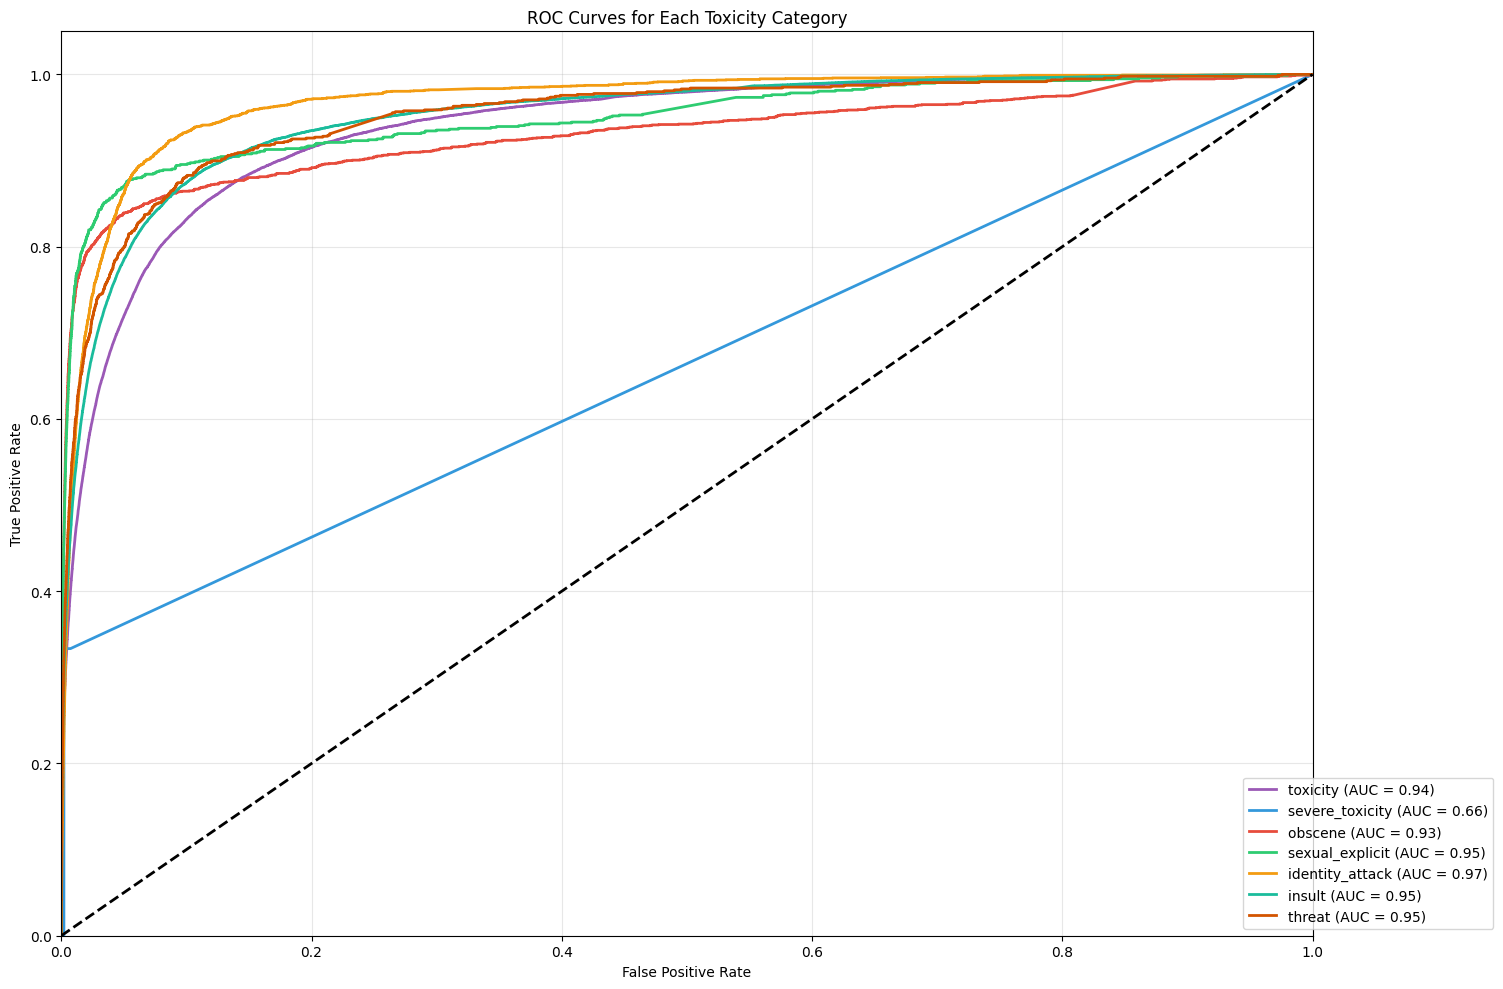

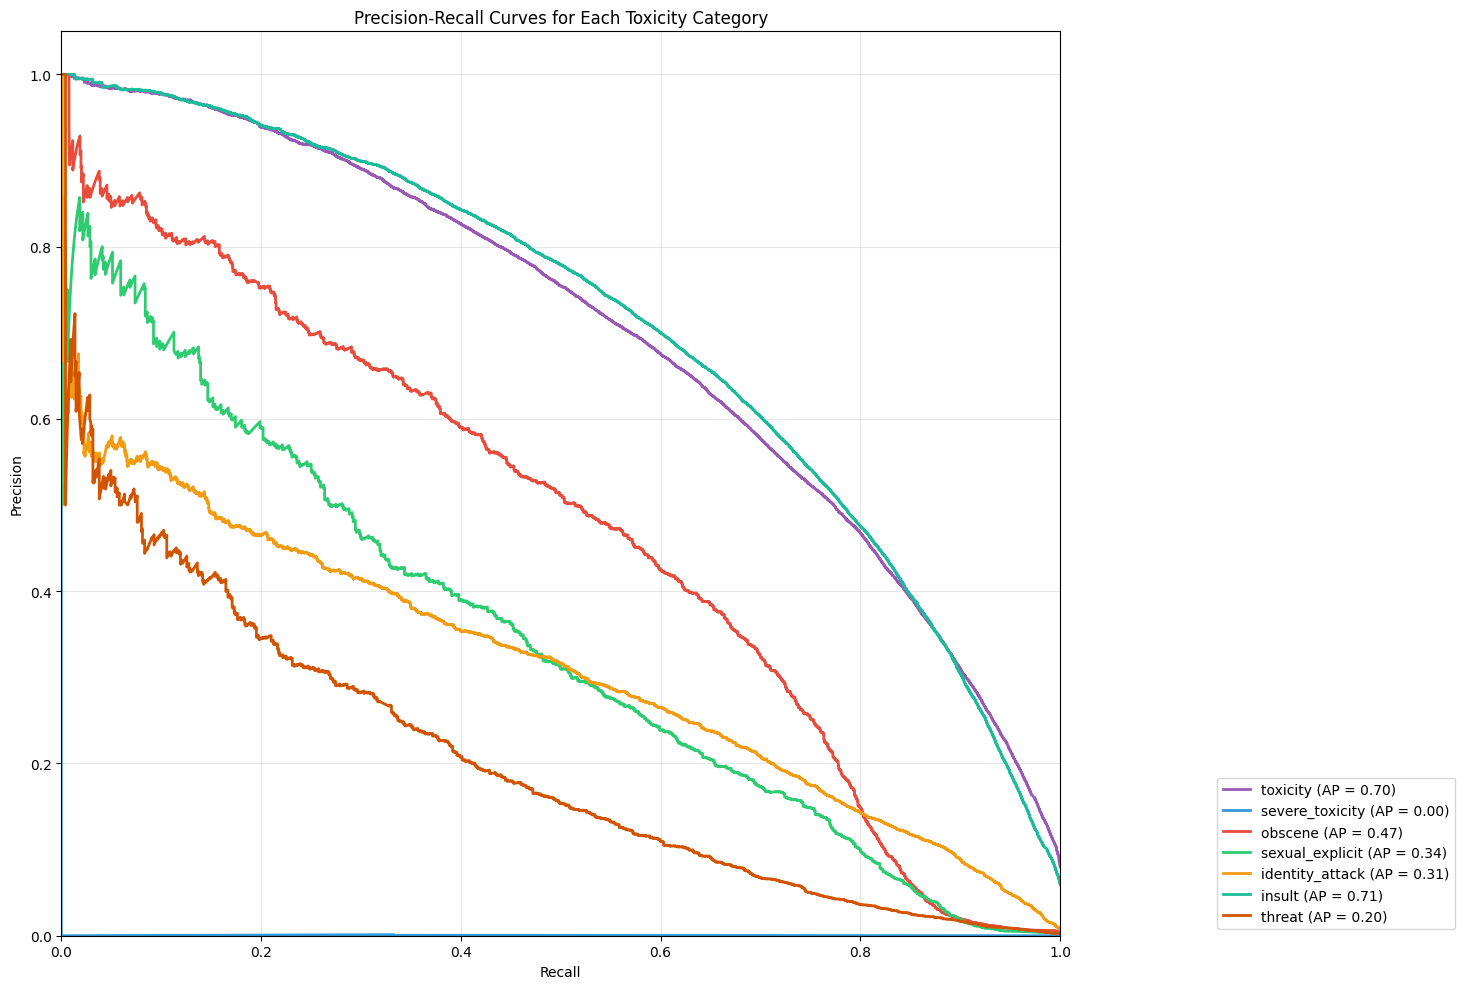

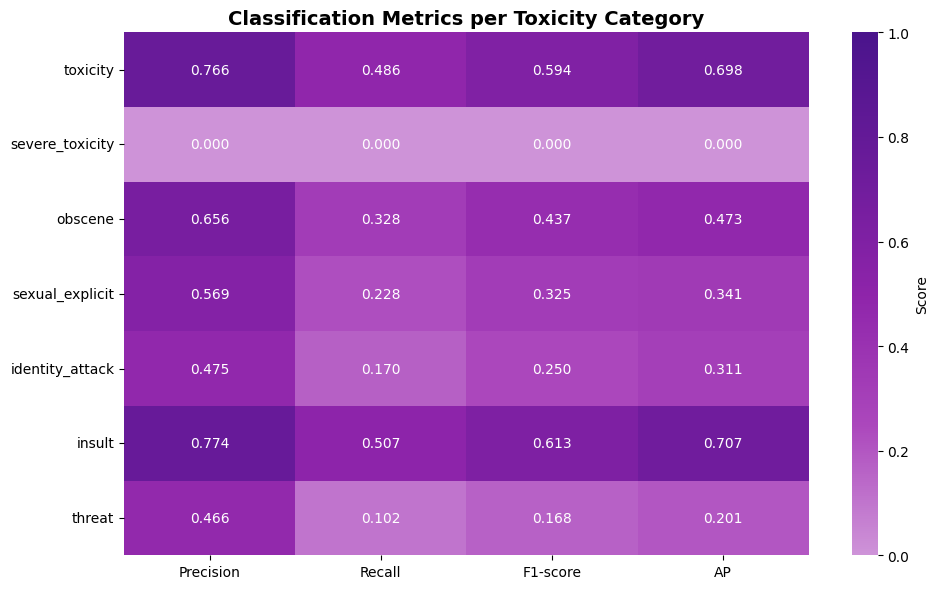

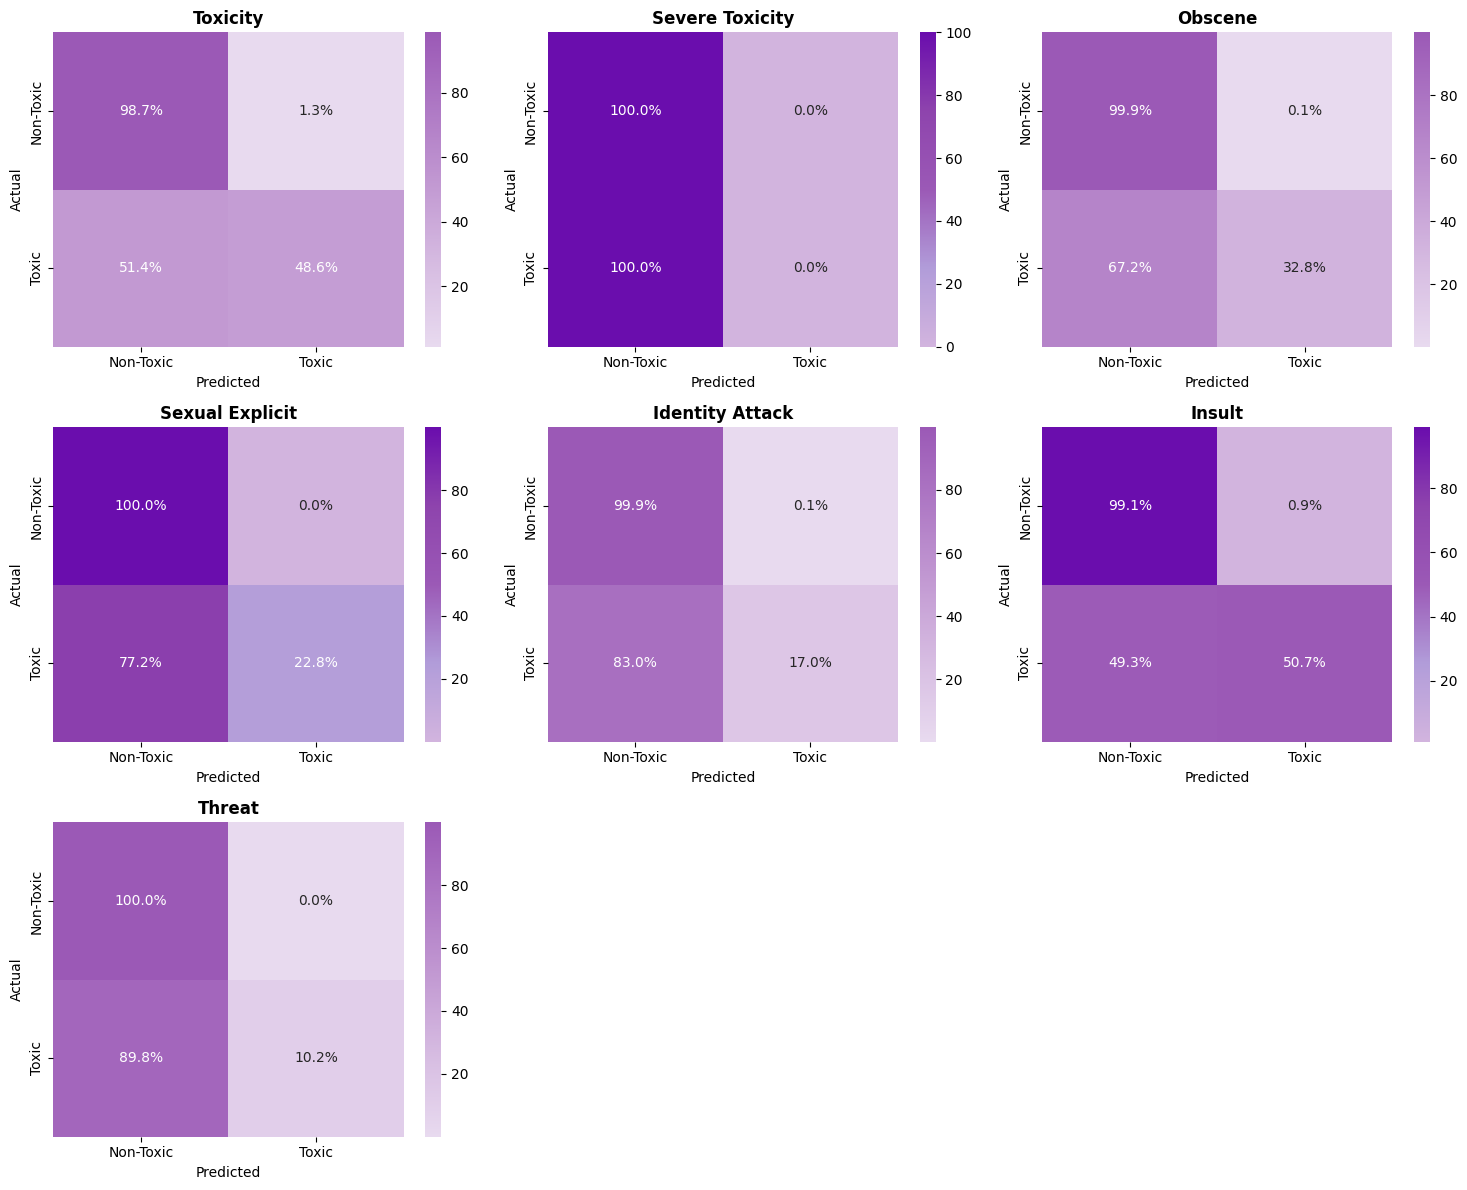

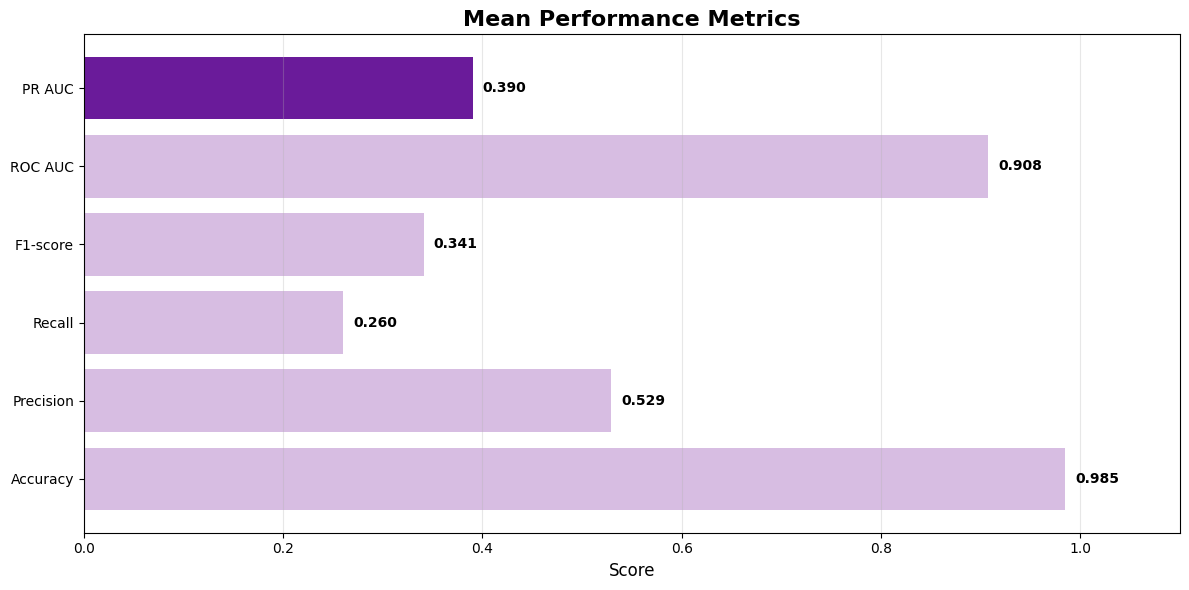


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.766
Recall: 0.486
F1-score: 0.594
Accuracy: 0.947
ROC AUC: 0.939
Average Precision: 0.698

Category: severe_toxicity
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Accuracy: 1.000
ROC AUC: 0.664
Average Precision: 0.000

Category: obscene
Precision: 0.656
Recall: 0.328
F1-score: 0.437
Accuracy: 0.996
ROC AUC: 0.931
Average Precision: 0.473

Category: sexual_explicit
Precision: 0.569
Recall: 0.228
F1-score: 0.325
Accuracy: 0.998
ROC AUC: 0.950
Average Precision: 0.341

Category: identity_attack
Precision: 0.475
Recall: 0.170
F1-score: 0.250
Accuracy: 0.993
ROC AUC: 0.968
Average Precision: 0.311

Category: insult
Precision: 0.774
Recall: 0.507
F1-score: 0.613
Accuracy: 0.962
ROC AUC: 0.950
Average Precision: 0.707

Category: threat
Precision: 0.466
Recall: 0.102
F1-score: 0.168
Accuracy: 0.998
ROC AUC: 0.951
Average Precision: 0.201

Mean Metrics Across All Toxicity Categ

In [77]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)
y_train_binary = (y_train >= 0.5).astype(int)

best_model.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_raw_data = evaluate_model(model=best_model, test_set=test_set)

## Baseline with Undersampled Dataset

> Baseline Model: Logistic Regression with Undersampling and Data from the Wikipedia dataset -> Merged Dataset + Undersampling

In [ ]:
# Load the dataset
df = pd.read_csv("../../data/merged_data/undersampled_dataset.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X = df['comment_text']  # Using the raw text as features
y = df[toxic_categories].values  # Multi-label target matrix

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['toxicity'] >= 0.5
)

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

Data loaded with shape: (911682, 32)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


> Feature Extraction with TF IDF

In [80]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (729345, 20000)
Testing set shape: (182337, 20000)
Target shape: (729345, 7)


Evaluating the model...


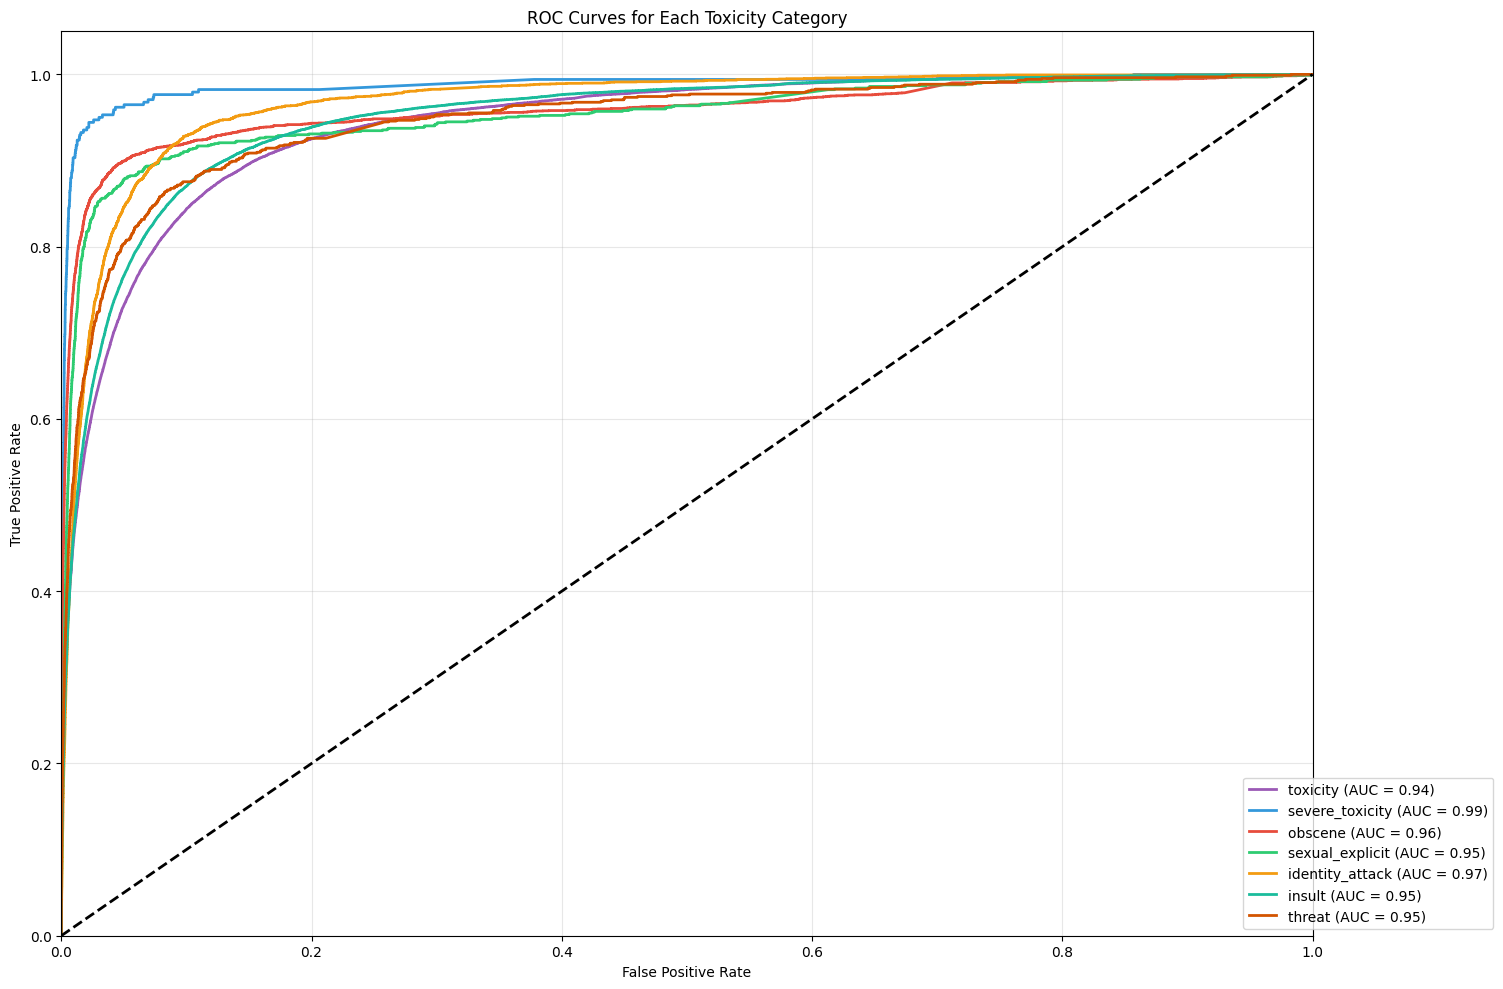

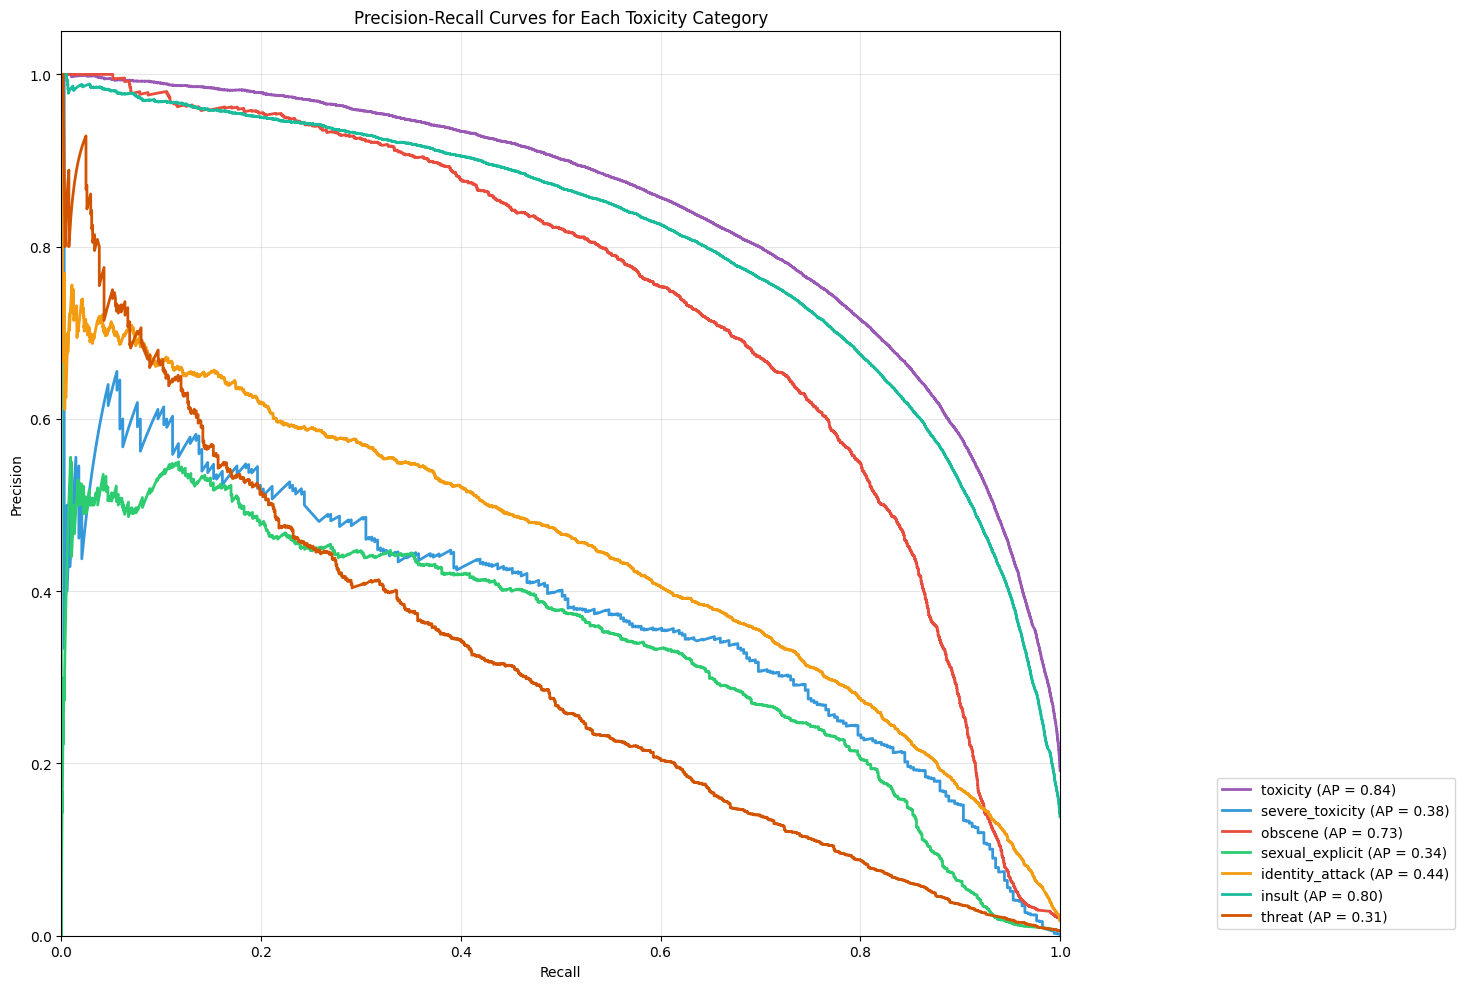

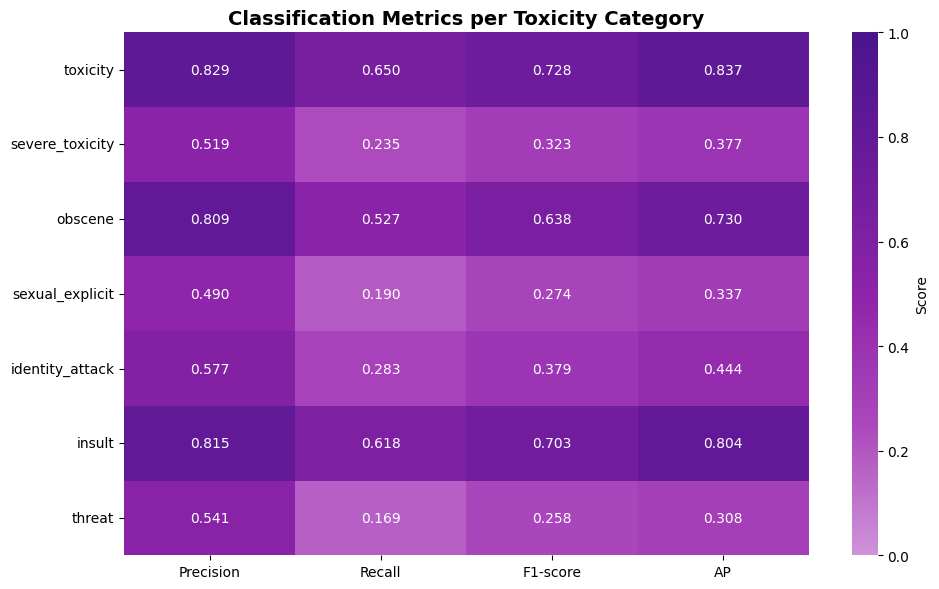

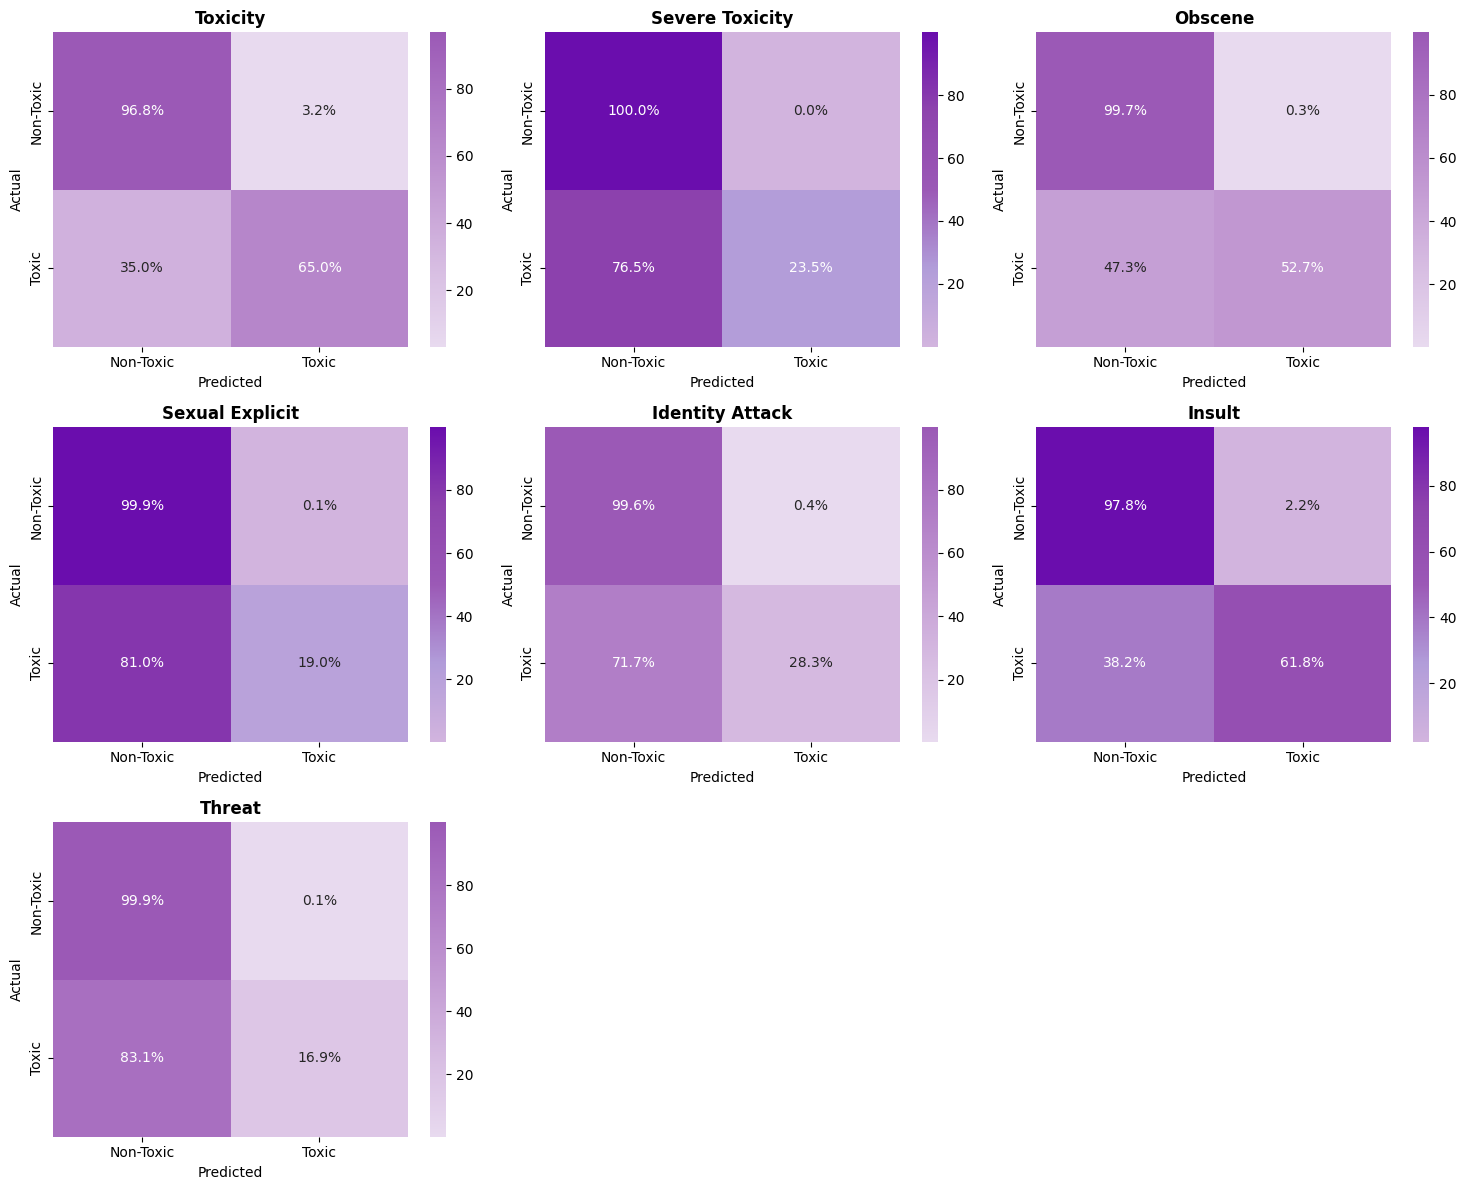

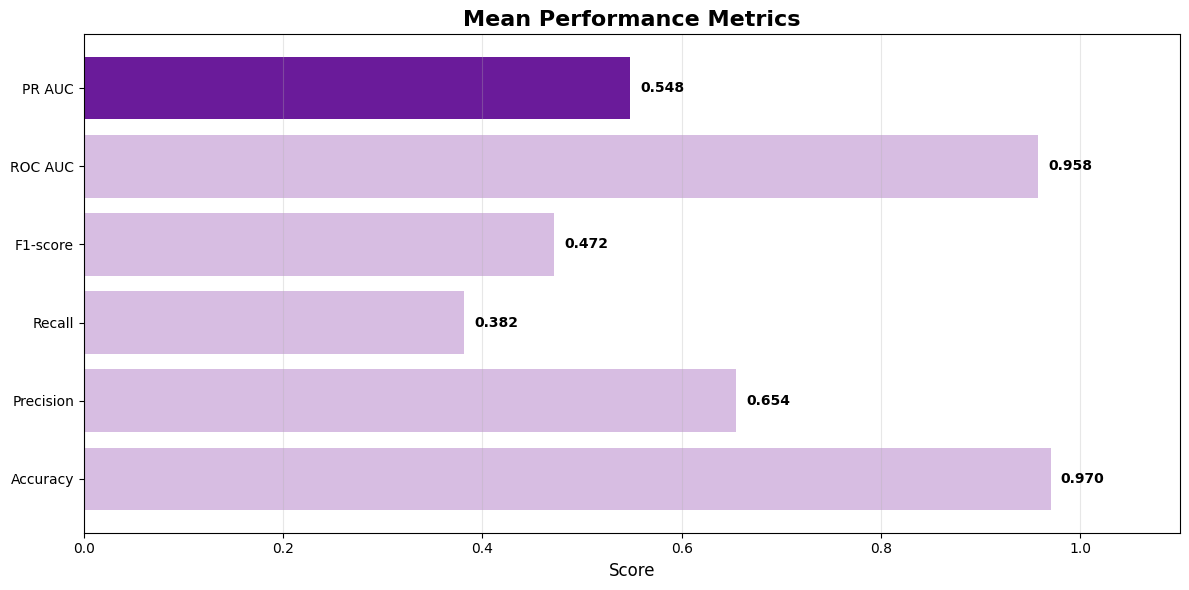


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.829
Recall: 0.650
F1-score: 0.728
Accuracy: 0.907
ROC AUC: 0.943
Average Precision: 0.837

Category: severe_toxicity
Precision: 0.519
Recall: 0.235
F1-score: 0.323
Accuracy: 0.998
ROC AUC: 0.987
Average Precision: 0.377

Category: obscene
Precision: 0.809
Recall: 0.527
F1-score: 0.638
Accuracy: 0.988
ROC AUC: 0.958
Average Precision: 0.730

Category: sexual_explicit
Precision: 0.490
Recall: 0.190
F1-score: 0.274
Accuracy: 0.994
ROC AUC: 0.953
Average Precision: 0.337

Category: identity_attack
Precision: 0.577
Recall: 0.283
F1-score: 0.379
Accuracy: 0.984
ROC AUC: 0.966
Average Precision: 0.444

Category: insult
Precision: 0.815
Recall: 0.618
F1-score: 0.703
Accuracy: 0.928
ROC AUC: 0.950
Average Precision: 0.804

Category: threat
Precision: 0.541
Recall: 0.169
F1-score: 0.258
Accuracy: 0.994
ROC AUC: 0.947
Average Precision: 0.308

Mean Metrics Across All Toxicity Categ

In [82]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


> Comparing with the Baseline using Raw Data

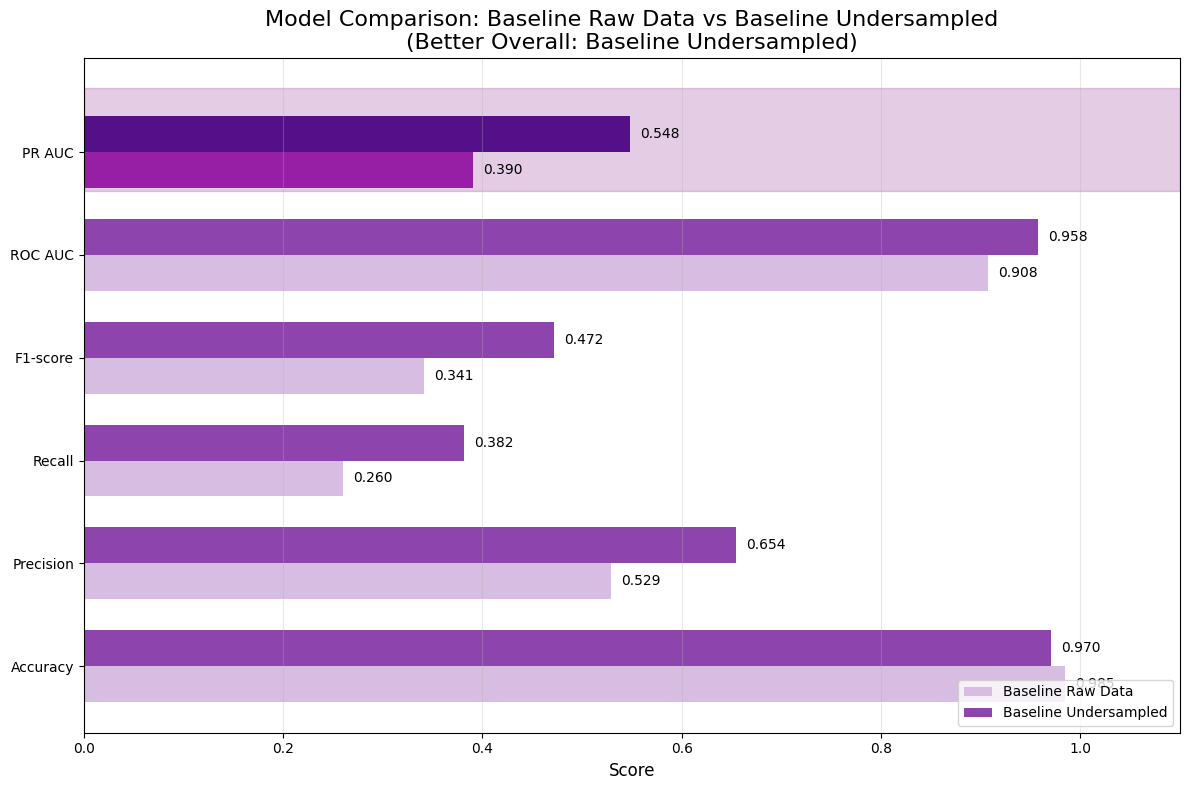


Numeric Comparison (Baseline Raw Data vs Baseline Undersampled):
--------------------------------------------------

Overall Metrics:
Accuracy    : 0.985 vs 0.970 (Diff: 0.014, Better: Baseline Raw Data)
Precision   : 0.529 vs 0.654 (Diff: 0.125, Better: Baseline Undersampled)
Recall      : 0.260 vs 0.382 (Diff: 0.122, Better: Baseline Undersampled)
F1-score    : 0.341 vs 0.472 (Diff: 0.131, Better: Baseline Undersampled)
ROC AUC     : 0.908 vs 0.958 (Diff: 0.050, Better: Baseline Undersampled)
PR AUC      : 0.390 vs 0.548 (Diff: 0.158, Better: Baseline Undersampled)

Per-Class Metrics:

toxicity:
precision   : 0.766 vs 0.829 (Diff: 0.063, Better: Baseline Undersampled)
recall      : 0.486 vs 0.650 (Diff: 0.164, Better: Baseline Undersampled)
f1_score    : 0.594 vs 0.728 (Diff: 0.134, Better: Baseline Undersampled)
accuracy    : 0.947 vs 0.907 (Diff: 0.040, Better: Baseline Raw Data)
roc_auc     : 0.939 vs 0.943 (Diff: 0.004, Better: Baseline Undersampled)
average_precision: 0.698 vs 

In [89]:
compare_models(
    evaluation_results_raw_data, 
    evaluation_results_undersampling, 
    model1_name="Baseline Raw Data", 
    model2_name="Baseline Undersampled"
)

# Baseline with Undersampling + Oversampling

> Baseline Model: Logistic Regression with Undersampling and Oversampling, this dataset already has the feature extraction done using Embeddings 

In [ ]:
categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
              'identity_attack', 'insult', 'threat']
# Load the combined dataset
combined_df = pd.read_csv('../../data/merged_data/combined_dataset_with_synthetic.csv')

# Determine which columns are embeddings and which are labels
embedding_cols = combined_df.columns[:-len(categories)]
label_cols = categories 

# Split the dataframe into features (X) and labels (y)
X = combined_df[embedding_cols]  # All embedding columns
y = combined_df[label_cols]      # All label columns

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(f"NaN values in X: {np.isnan(X).sum()}")
print(f"Infinity values in X: {np.isinf(X).sum()}")
print(f"Min value in X: {np.min(X)}")
print(f"Max value in X: {np.max(X)}")

# Convert labels to binary 
y_binary = (y >= 0.5).astype(int)

# Now split the data
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=combined_df['toxicity'] >= 0.5
)

print(f"Training set: X shape {X_train.shape}, y shape {y_train_binary.shape}")
print(f"Test set: X shape {X_test.shape}, y shape {y_test_binary.shape}")


X shape: (921727, 384)
y shape: (921727, 7)
NaN values in X: 0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Length: 384, dtype: int64
Infinity values in X: 0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Length: 384, dtype: int64
Min value in X: -0.416830450296402
Max value in X: 0.4335273504257202
Training set: X shape (737381, 384), y shape (737381, 7)
Test set: X shape (184346, 384), y shape (184346, 7)


In [4]:
print("Training the model...")
model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='saga',
    max_iter=2000,
    # class_weight=None,
    random_state=42
)
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train, y_train_binary)

Training the model...


OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000, random_state=42,
                                                 solver='saga'))

In [ ]:
# Evaluate the model
print("Evaluating the model...")
evaluation_results = evaluate_model(model=multilabel_classifier, test_set=(X_test, y_test_binary))

0.8144847189524047


/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-pac

> For some reason this dataset if underperfoming and giving a division by zero warning. 